In [3]:
# Data augumentation video
# Tensorflow video
# Fast API video 
# TF serving video

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../3_Data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [6]:
dataset_class_names=dataset.class_names
print(dataset_class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


(32, 256, 256, 3)
[2 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 1 1 0 0 0 2 2 0 1 1 0]


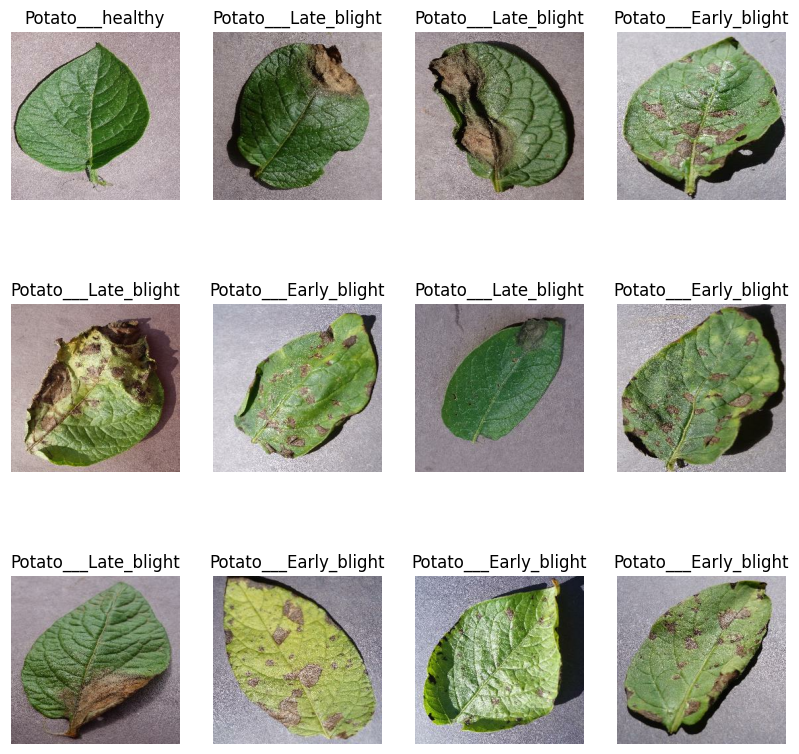

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(dataset_class_names[label_batch[i]])
        plt.axis("off")

# Training Testing Spliting 
## 80%==>Training 
## 20%==>Testing
###    10%==>Validation
###    10%==>Testing

In [8]:
train_size=0.8
len(dataset)

68

In [9]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [10]:
# Training dataset
train_ds=dataset.take(54)
len(train_ds)

54

In [11]:
# Initial test dataset as 20 %
test_ds=dataset.skip(54)
len(test_ds)

14

In [12]:
# Spliting testing dataset into validation and testing
# Validation dataset
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
#Testing daset
test_ds=test_ds.skip(6)
len(test_ds)

8

### For the above steps let's create a fuction that can return or Split our data to :- 
#### Train 
#### Test
#### Validation 

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split+test_split+val_split)==1

    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)


    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

54
6
8


Cache, Shuffle, and Prefetch the Dataset

In [17]:
# Data augumentaion
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
# Normalization on images
for image_batch, labels_batch in dataset.take(1):
    print(image_batch[0].numpy()/255)

[[[0.53333336 0.50980395 0.54901963]
  [0.57254905 0.54901963 0.5882353 ]
  [0.41960785 0.39607844 0.43529412]
  ...
  [0.65882355 0.64705884 0.6745098 ]
  [0.6117647  0.6        0.627451  ]
  [0.7254902  0.7137255  0.7411765 ]]

 [[0.49803922 0.4745098  0.5137255 ]
  [0.4745098  0.4509804  0.49019608]
  [0.69803923 0.6745098  0.7137255 ]
  ...
  [0.65882355 0.64705884 0.6745098 ]
  [0.69411767 0.68235296 0.70980394]
  [0.77254903 0.7607843  0.7882353 ]]

 [[0.63529414 0.6117647  0.6509804 ]
  [0.45882353 0.43529412 0.4745098 ]
  [0.6862745  0.6627451  0.7019608 ]
  ...
  [0.6784314  0.6666667  0.69411767]
  [0.72156864 0.70980394 0.7372549 ]
  [0.6862745  0.6745098  0.7019608 ]]

 ...

 [[0.5019608  0.49019608 0.53333336]
  [0.5294118  0.5176471  0.56078434]
  [0.53333336 0.52156866 0.5647059 ]
  ...
  [0.4862745  0.47843137 0.52156866]
  [0.52156866 0.5137255  0.5568628 ]
  [0.52156866 0.5137255  0.5568628 ]]

 [[0.4745098  0.4627451  0.5058824 ]
  [0.5058824  0.49411765 0.5372549 ]


### Building the Model

In [19]:
# Resize and Rescaling
resize_and_rescale=tf.keras.Sequential([
    # Resizing the image because some image are not same size for rescaling
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    # Rescaling the image in the range of 0-1
    layers.Rescaling(1.0/255)
]
)

### Data Augmentation

In [20]:
# Data augmentation for taking different images by (contrast, zoom, angle, rotate) 
# Here only used as rotate
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

### Others Data augmentations
    # Zoom
    tf.keras.layers.RandomZoom(0.2),  
    
    # Contrast
    tf.keras.layers.RandomContrast(0.2),  
    
    # Translations (shift in height/width)
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  


### Applying Data Augmentation to Train Dataset

In [1]:
train_ds=train_ds.map(
    lambda x,y:(data_augmentation(x, training=True),y),
).prefetch(buffer_size=tf.data.AUTOTUNE)

NameError: name 'train_ds' is not defined

### Model Training has mainly "Three step"
#### 1. Model Architecture
#### 2. Model Optimization (like loss, accuracy)
#### 3. Model Evaluation (test data)

In [24]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # no batch size here
n_classes = 3

model = models.Sequential([
    layers.Input(shape=input_shape),   # define input here once
    resize_and_rescale,
    data_augmentation,

    # Convolution & ReLU + Pooling
    layers.Conv2D(32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    # Flatten Layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),

    # Output Layer
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)


In [25]:
# Model Structure Summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

### Model Compilation & Optimization

In [26]:

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
# Train the model and calculate accuracy and loss
history=model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 61s 917ms/step - accuracy: 0.5087 - loss: 0.8789 - val_accuracy: 0.7083 - val_loss: 0.6995
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 739ms/step - accuracy: 0.7361 - loss: 0.6317 - val_accuracy: 0.8490 - val_loss: 0.4319
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 640ms/step - accuracy: 0.8287 - loss: 0.4107 - val_accuracy: 0.8646 - val_loss: 0.3338
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 639ms/step - accuracy: 0.8669 - loss: 0.3158 - val_accuracy: 0.8646 - val_loss: 0.3563
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 660ms/step - accuracy: 0.8889 - loss: 0.2698 - val_accuracy: 0.8906 - val_loss: 0.3289
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 633ms/step - accuracy: 0.8941 - loss: 0.2529 - val_accuracy: 0.8906 - val_loss: 0.3285
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 34s 637ms/step - accuracy: 0.9109 - loss: 0.2170 - val_accuracy: 0.9062 - val_loss: 0.2425
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 35s 642ms/step - accuracy: 0.9265 - loss: 0.1882 - val_accu

In [28]:
len(test_ds)

8

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.9727 - loss: 0.0829


In [30]:
# check in which parameters the model is train 
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [31]:
# A Dictionary that contains loss, accuracy, val_loss, val_accuracy
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [32]:
# check all losses of the training model like ( accuracy, val_loss, val_accuracy)
history.history['loss']

[0.8789191842079163,
 0.6317288279533386,
 0.41067954897880554,
 0.3157554864883423,
 0.2698255777359009,
 0.2529314458370209,
 0.21703632175922394,
 0.18821370601654053,
 0.1598922610282898,
 0.1501014530658722,
 0.1545344591140747,
 0.12829247117042542,
 0.12994913756847382,
 0.11443907022476196,
 0.1373942792415619,
 0.10382062941789627,
 0.12789779901504517,
 0.11421769112348557,
 0.10616131871938705,
 0.06891701370477676,
 0.07409142702817917,
 0.08736047148704529,
 0.06262065470218658,
 0.05699780955910683,
 0.04911186173558235,
 0.057241290807724,
 0.038242291659116745,
 0.05038866400718689,
 0.04329569637775421,
 0.05975966900587082,
 0.04417888820171356,
 0.04230153188109398,
 0.0845605880022049,
 0.0699438527226448,
 0.05226418375968933,
 0.03715931624174118,
 0.024919256567955017,
 0.03773219510912895,
 0.04618597775697708,
 0.033412523567676544,
 0.04501168802380562,
 0.02502358891069889,
 0.044687047600746155,
 0.029620759189128876,
 0.030916059389710426,
 0.01769260317087

In [33]:
# Plotting loss, accuracy, val_loss, val_accuracy
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

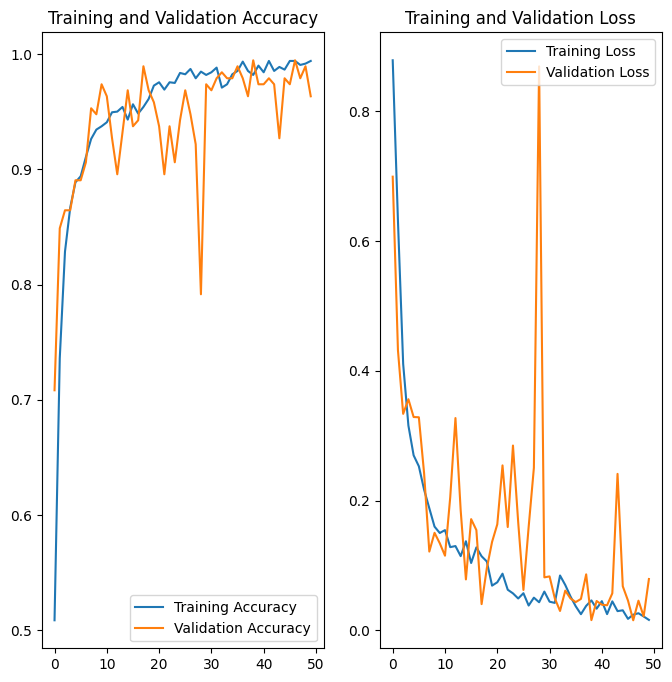

In [34]:
# Plotting
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS), val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title ('Training and Validation Loss')

plt.show()

### Run prediction on a sample image

First Image to predict
Actual Label:  Potato___healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Predicted Label:  Potato___healthy


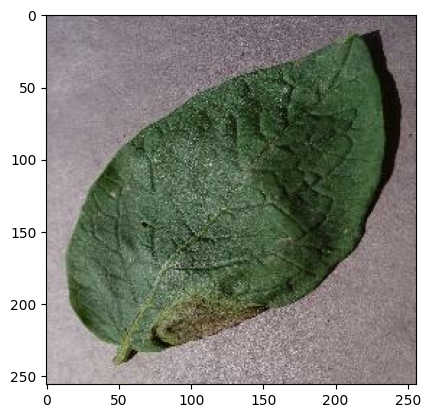

In [36]:
# Check the model is currectly predicting or Not
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    # Show the image first
    print("First Image to predict")
    plt.imshow(first_image)
    # prediction on Batch wise (batch size is 32)
    print("Actual Label: ",dataset_class_names[label_batch[0].numpy()])
    batch_prediction=model.predict(images_batch)
    # out of 32 check for 1st image
    print("Predicted Label: ",dataset_class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [37]:
# Prediction Function
def predict (model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) # Create a batch

    predictions=model.predict(img_array)

    predicted_class=dataset_class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


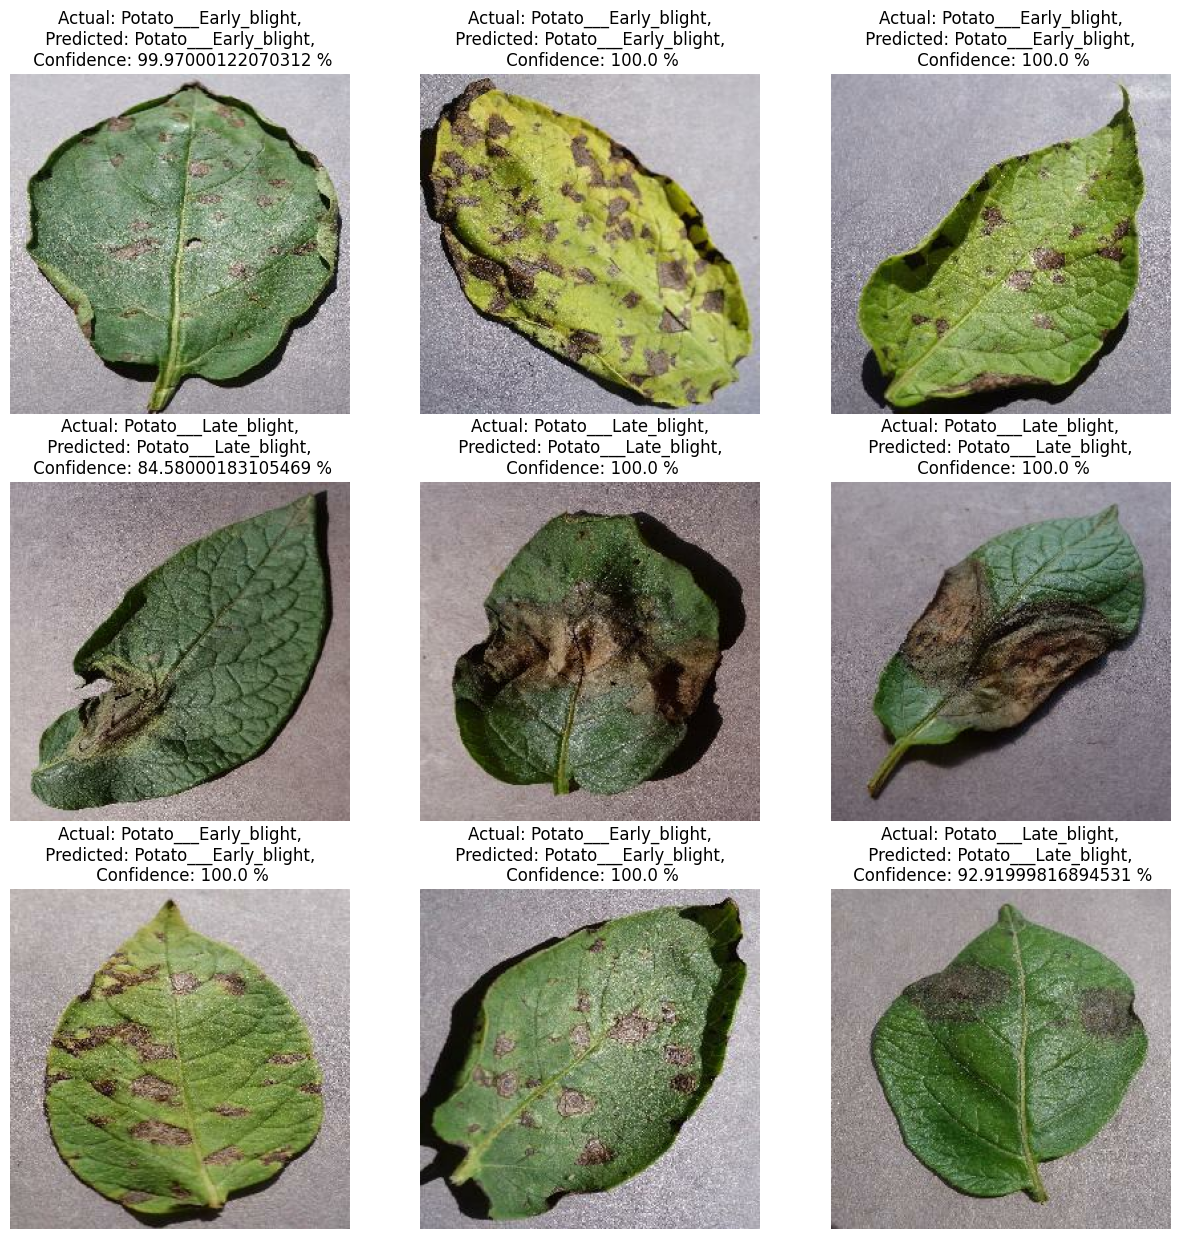

In [38]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
# Actual class 
        actual_class=dataset_class_names[labels[i]]
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence} %")
        plt.axis("off")


In [ ]:
# Save the models
import os

# Get latest version number
model_version = max([int(i) for i in os.listdir("../4_Models")] + [0]) + 1

# Export in SavedModel format
model.save(f"../4_Models/{model_version}")

In [39]:
# Save the models
model.save(f"../4_Models/potatoes.h5")

INFO:tensorflow:Assets written to: ../4_Models/2\assets


INFO:tensorflow:Assets written to: ../4_Models/2\assets


Saved artifact at '../4_Models/2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_64')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2189974652688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189974663056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2190110401232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2190110402384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189974652496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2190110402576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2190110400080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2190110402960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2190110402768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2190110403344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2190110403152: TensorSpec(shape=()